In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# pip install tensorflow==2.9.0

In [3]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1,EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os

Train Set


Loading pituitary: 100%|██████████| 4555/4555 [02:35<00:00, 29.21it/s] 



Test Set


Loading pituitary: 100%|██████████| 279/279 [00:05<00:00, 49.45it/s] 



Image Shape
x train= (13996, 240, 240, 3)
y train= (13996,)
x test= (920, 240, 240, 3)
y test= (920,)

Sample Images


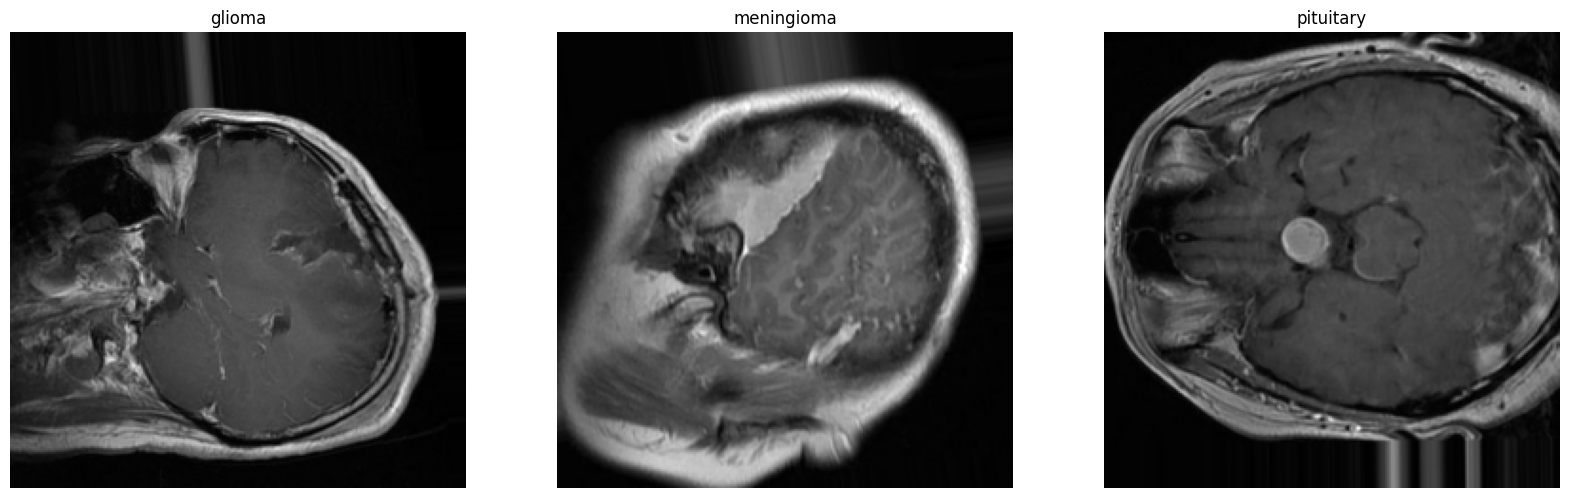

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def load_images(folder_path, labels, image_size):
    images = []
    class_labels = []
    for label in labels:
        label_folder = os.path.join(folder_path, label)
        for image_name in tqdm(os.listdir(label_folder), desc=f"Loading {label}"):
            image_path = os.path.join(label_folder, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (image_size, image_size))
            images.append(image)
            class_labels.append(label)
    return np.array(images), np.array(class_labels)

def main():
    base_folder = '/content/drive/MyDrive'
    Aug_folder = 'Aug_images_70_30_Split_With_Brightness'
    split_folder = 'split_images'

    labels = ['glioma', 'meningioma', 'pituitary']
    image_size = 240
    
    print("Train Set")
    print("===========")
    train_folder_path = os.path.join(base_folder, Aug_folder)
    X_train, y_train = load_images(train_folder_path, labels, image_size)

    print("\nTest Set")
    print("=========")
    test_folder_path = os.path.join(base_folder, split_folder, 'test')
    X_test, y_test = load_images(test_folder_path, labels, image_size)

    print("\nImage Shape")
    print("===========")
    print("x train=", X_train.shape)
    print("y train=", y_train.shape)
    print("x test=", X_test.shape)
    print("y test=", y_test.shape)

    # Shuffle the dataset
    X_train, y_train = shuffle(X_train, y_train, random_state=100)
    X_test, y_test = shuffle(X_test, y_test, random_state=100)

    return X_train, y_train, X_test, y_test, labels

if __name__ == "__main__":
    X_train, y_train, X_test, y_test, labels = main()


# Plot example images from each class
    print("\nSample Images")
    print("===========")
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[labels.index(i)].imshow(X_train[j])
            ax[labels.index(i)].set_title(i)
            ax[labels.index(i)].axis('off')
            break
        j += 1

plt.show()

# label encoding

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
# Load the EfficientNetB1 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model1 = Model(inputs=base_model.inputs, outputs=predictions)

16705208/16705208 [==============================] - 2s 0us/step


In [6]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb0_Aug_best.h5', monitor='val_accuracy', save_best_only=True)
    
# Compile the model1
model1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [7]:
# Train the model with the ModelCheckpoint callback
history = model1.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
394/394 [==============================] - 126s 276ms/step - loss: 0.1925 - accuracy: 0.9313 - val_loss: 0.1299 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 2/40
394/394 [==============================] - 106s 269ms/step - loss: 0.0720 - accuracy: 0.9762 - val_loss: 0.0523 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/40
394/394 [==============================] - 106s 269ms/step - loss: 0.0475 - accuracy: 0.9837 - val_loss: 0.0721 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 4/40
394/394 [==============================] - 105s 268ms/step - loss: 0.0382 - accuracy: 0.9878 - val_loss: 0.0621 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 5/40
394/394 [==============================] - 106s 268ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.1362 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 6/40
394/394 [==============================] - 106s 270ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0024 - val_accuracy: 0.9993 - lr: 2.0000e-04
Epoch 7/40
394/394 [======================

In [8]:
# Evaluate the model on the test set
loss, accuracy = model1.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

29/29 [==============================] - 2s 63ms/step - loss: 0.0475 - accuracy: 0.9902
Test Accuracy: 0.990217387676239


In [9]:
# Load the EfficientNetB1 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model2 = Model(inputs=base_model.inputs, outputs=predictions)

27018416/27018416 [==============================] - 2s 0us/step


In [10]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb1_Aug_best.h5', monitor='val_accuracy', save_best_only=True)
    
# Compile the model
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [11]:
# Train the model with the ModelCheckpoint callback
history = model2.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
394/394 [==============================] - 181s 428ms/step - loss: 0.1957 - accuracy: 0.9281 - val_loss: 0.0944 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 2/40
394/394 [==============================] - 165s 420ms/step - loss: 0.0685 - accuracy: 0.9775 - val_loss: 0.0563 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 3/40
394/394 [==============================] - 164s 417ms/step - loss: 0.0526 - accuracy: 0.9820 - val_loss: 0.0633 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 4/40
394/394 [==============================] - 164s 416ms/step - loss: 0.0311 - accuracy: 0.9904 - val_loss: 0.1192 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/40
394/394 [==============================] - 166s 420ms/step - loss: 0.0335 - accuracy: 0.9904 - val_loss: 0.0422 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 6/40
394/394 [==============================] - 165s 419ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.0362 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 7/40
394/394 [==========================

In [12]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

29/29 [==============================] - 3s 86ms/step - loss: 0.0387 - accuracy: 0.9924
Test Accuracy: 0.9923912882804871


In [13]:
# Load the EfficientNetB2 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model3 = Model(inputs=base_model.inputs, outputs=predictions)

31790344/31790344 [==============================] - 2s 0us/step


In [14]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb2_Aug_best.h5', monitor='val_accuracy', save_best_only=True)
    
# Compile the model
model3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [15]:
# Train the model with the ModelCheckpoint callback
history = model3.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
394/394 [==============================] - 190s 451ms/step - loss: 0.2030 - accuracy: 0.9248 - val_loss: 0.1485 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 2/40
394/394 [==============================] - 174s 441ms/step - loss: 0.0779 - accuracy: 0.9748 - val_loss: 0.0349 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/40
394/394 [==============================] - 173s 438ms/step - loss: 0.0498 - accuracy: 0.9843 - val_loss: 0.0347 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 4/40
394/394 [==============================] - 172s 437ms/step - loss: 0.0393 - accuracy: 0.9877 - val_loss: 0.0273 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 5/40
394/394 [==============================] - 173s 440ms/step - loss: 0.0297 - accuracy: 0.9899 - val_loss: 0.0077 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 6/40
394/394 [==============================] - 173s 438ms/step - loss: 0.0326 - accuracy: 0.9901 - val_loss: 0.1069 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 7/40
394/394 [==========================

In [16]:
# Evaluate the model on the test set
loss, accuracy = model3.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

29/29 [==============================] - 3s 89ms/step - loss: 0.0836 - accuracy: 0.9902
Test Accuracy: 0.990217387676239


In [17]:
# Load the EfficientNetB3 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model4 = Model(inputs=base_model.inputs, outputs=predictions)

43941136/43941136 [==============================] - 3s 0us/step


In [18]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb3_Aug_best.h5', monitor='val_accuracy', save_best_only=True)
    
# Compile the model
model4.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [19]:
# Train the model with the ModelCheckpoint callback
history = model4.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
394/394 [==============================] - 245s 582ms/step - loss: 0.2010 - accuracy: 0.9312 - val_loss: 0.1599 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 2/40
394/394 [==============================] - 224s 569ms/step - loss: 0.0813 - accuracy: 0.9738 - val_loss: 0.0438 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/40
394/394 [==============================] - 223s 566ms/step - loss: 0.0498 - accuracy: 0.9838 - val_loss: 0.0934 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 4/40
394/394 [==============================] - 224s 569ms/step - loss: 0.0390 - accuracy: 0.9879 - val_loss: 0.0243 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 5/40
394/394 [==============================] - 224s 568ms/step - loss: 0.0308 - accuracy: 0.9892 - val_loss: 0.0121 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 6/40
394/394 [==============================] - 223s 566ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0910 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 7/40
394/394 [==========================

In [20]:
# Evaluate the model on the test set
loss, accuracy = model4.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

29/29 [==============================] - 3s 118ms/step - loss: 0.0426 - accuracy: 0.9902
Test Accuracy: 0.990217387676239


In [21]:
# Load the EfficientNetB4 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model5 = Model(inputs=base_model.inputs, outputs=predictions)

71686520/71686520 [==============================] - 5s 0us/step


In [22]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb4_Aug_best.h5', monitor='val_accuracy', save_best_only=True)
    
# Compile the model
model5.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model with the ModelCheckpoint callback
history = model5.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
394/394 [==============================] - 322s 770ms/step - loss: 0.2009 - accuracy: 0.9330 - val_loss: 0.3365 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 2/40
394/394 [==============================] - 298s 755ms/step - loss: 0.0636 - accuracy: 0.9799 - val_loss: 0.0491 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 3/40
394/394 [==============================] - 298s 756ms/step - loss: 0.0502 - accuracy: 0.9852 - val_loss: 0.0279 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 4/40
394/394 [==============================] - 298s 755ms/step - loss: 0.0448 - accuracy: 0.9856 - val_loss: 0.0093 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 5/40
394/394 [==============================] - 296s 752ms/step - loss: 0.0351 - accuracy: 0.9887 - val_loss: 1.0599 - val_accuracy: 0.9157 - lr: 0.0010
Epoch 6/40
394/394 [==============================] - 296s 750ms/step - loss: 0.0251 - accuracy: 0.9925 - val_loss: 0.0155 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 7/40
394/394 [==========================

In [23]:
# Evaluate the model on the test set
loss, accuracy = model5.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

29/29 [==============================] - 5s 158ms/step - loss: 0.0426 - accuracy: 0.9913
Test Accuracy: 0.991304337978363


In [ ]:
import shutil

# Specify the source and destination paths
source_path = '/content/effnetb0_best.h5'
destination_dir = '/content/drive/MyDrive/'

# Move the file to the destination directory
shutil.move(source_path, destination_dir + 'effnetb0_best.h5')


'/content/drive/MyDrive/effnetb0_best.h5'

In [25]:
import shutil

# # Specify the source and destination paths
# source_path = '/content/effnetb0_Aug_best.h5'
# destination_dir = '/content/drive/MyDrive/effnetb0_Aug_best.h5'

# # Move the file to the destination directory
# shutil.move(source_path, destination_dir)

# # Specify the source and destination paths
# source_path = '/content/effnetb1_Aug_best.h5'
# destination_dir = '/content/drive/MyDrive/effnetb1_Aug_best.h5'

# # Move the file to the destination directory
# shutil.move(source_path, destination_dir)

# source_path = '/content/effnetb2_Aug_best.h5'
# destination_dir = '/content/drive/MyDrive/effnetb2_Aug_best.h5'

# # Move the file to the destination directory
# shutil.move(source_path, destination_dir)

source_path = '/content/effnetb4_Aug_best.h5'
destination_dir = '/content/drive/MyDrive/effnetb4_Aug_best.h5'

# Move the file to the destination directory
shutil.move(source_path, destination_dir)

'/content/drive/MyDrive/effnetb4_Aug_best.h5'